In [30]:
import numpy as np
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import HomeMade as hm
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
# import sklearn as sk
# LDA = sk.discriminant_analysis.LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

In [4]:
N = 1e8

all_features = "v0_ks_mass v0_ks_massErr pv0_x pv0_y pv0_z a0xy a0 a0z cosTheta v0_chi2 \
v0_x v0_y v0_z v0_rxy v0_rxyErr v0_px v0_py v0_pz v0_pt v0_p \
v0_ptErr \
v0_px1 v0_py1 v0_pz1 v0_pt1 \
v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 \
v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 \
epsilon2 Alpha pL1 pL2 pT thetastar rapidity_ks pseudorapidity".split(" ")

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(all_features, entrystop = N)

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(all_features + ['trueKs'], entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
train_test_slice = int(len(data)*0.8)
train_data = data[:train_test_slice]
test_data = data[train_test_slice:]

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)]
train_test_slice = int(len(mc)*0.8)
train_mc = mc[:train_test_slice]
test_mc = mc[train_test_slice:]

Linearly correlated features, based on figure by Johann
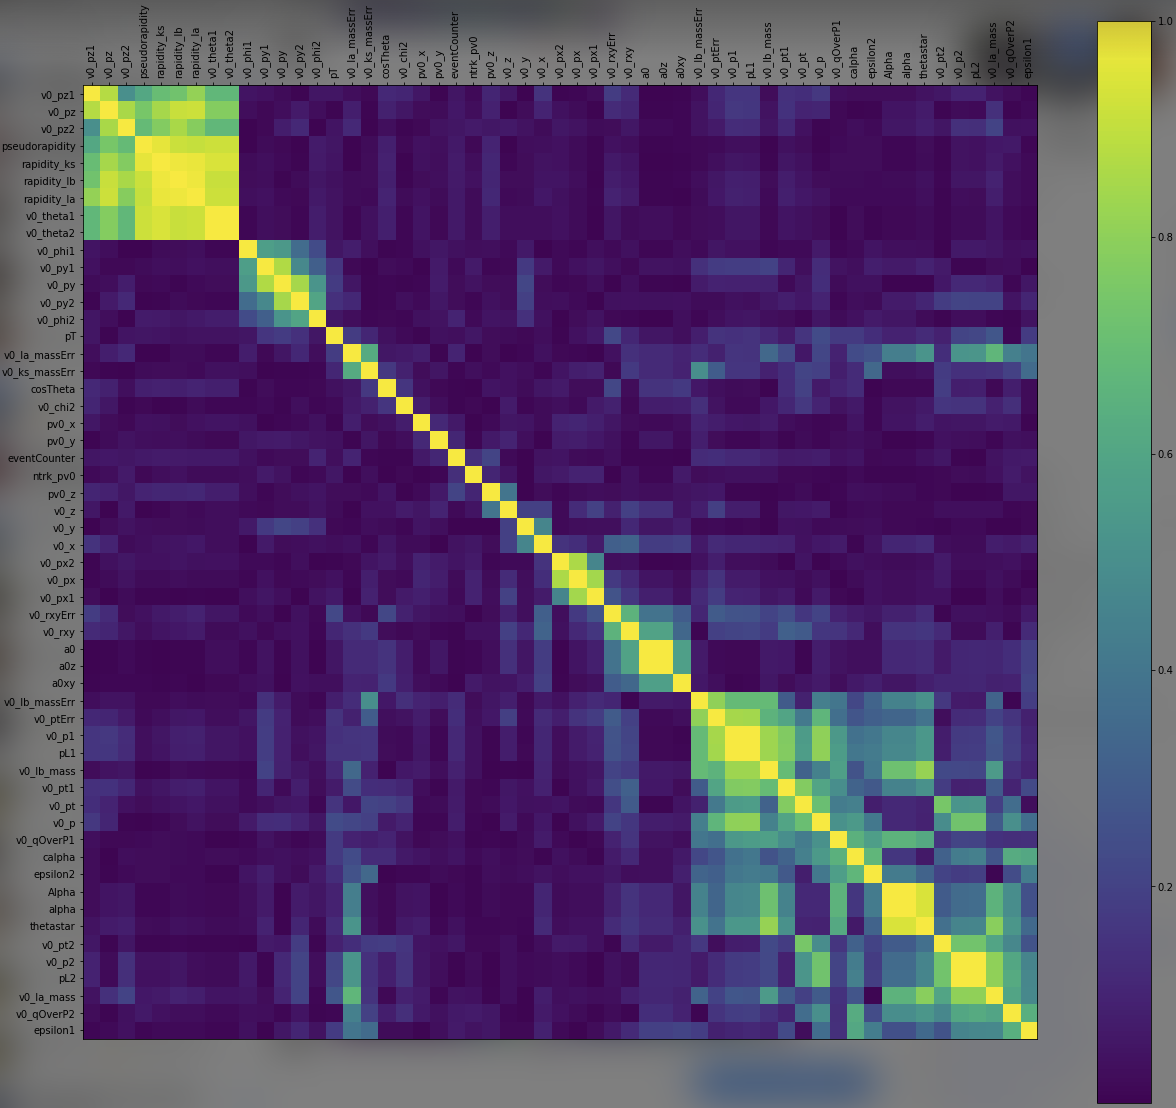

In [5]:
f1 = "v0_pz1 v0_pz v0_pz2 pseudorapidity rapidity_ks v0_theta1 v0_theta2".split(" ")
f2 = "v0_phi1 v0_py1 v0_py v0_py2 v0_phi2 pT".split(" ")
f3 = "v0_px2 v0_px v0_px1".split(" ")
f4 = "v0_rxyErr v0_rxy a0 a0xy".split(" ")
f5 = "v0_ptErr v0_p1 pL1 v0_pt1 v0_pt v0_p v0_qOverP1 calpha epsilon2 Alpha alpha thetastar".split(" ")
fs = [f1,f2,f3,f4,f5]

C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


No valid minimum found!


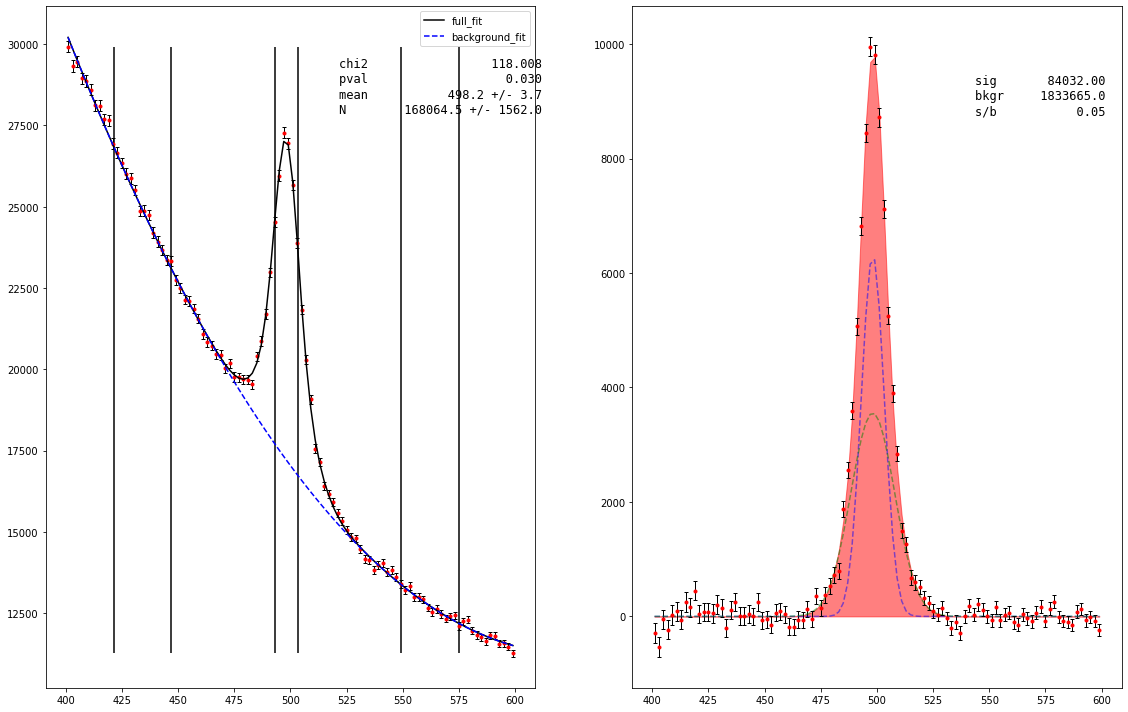

In [6]:
train_data = hm.assign_pseudolabels(train_data)

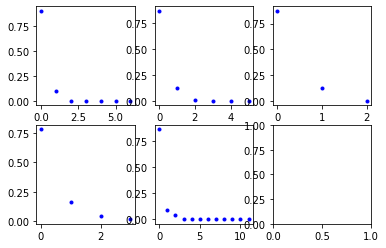

In [7]:
fig, ax = plt.subplots(ncols=3,nrows=2)
ax = ax.flatten()
for i, f in enumerate(fs):
    pca = PCA()
    pca.fit(train_data[f])
    ax[i].plot(pca.explained_variance_ratio_,'b.')

In [8]:
pca1 = PCA()
pca2 = PCA()
pca3 = PCA()
pca4 = PCA()
pca5 = PCA()
pca_cla = xgb.XGBClassifier()
pca_cla.fit(np.concatenate([pca1.fit_transform(train_data[fs[0]]),
                            pca2.fit_transform(train_data[fs[1]]),
                            pca3.fit_transform(train_data[fs[2]]),
                            pca4.fit_transform(train_data[fs[3]]),
                            pca5.fit_transform(train_data[fs[4]])],axis=1),y=train_data.y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [9]:
cla = xgb.XGBClassifier()
cla.fit(train_data[np.asarray(fs).sum()],y=train_data.y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [10]:
pca_p = pca_cla.predict_proba(np.concatenate([pca1.transform(test_data[fs[0]]),
                            pca2.transform(test_data[fs[1]]),
                            pca3.transform(test_data[fs[2]]),
                            pca4.transform(test_data[fs[3]]),
                            pca5.transform(test_data[fs[4]])],axis=1))[:,0]
p = cla.predict_proba(test_data[np.asarray(fs).sum()])[:,0]

pca_cla.score(np.concatenate([pca1.transform(train_data[fs[0]]),
                            pca2.transform(train_data[fs[1]]),
                            pca3.transform(train_data[fs[2]]),
                            pca4.transform(train_data[fs[3]]),
                            pca5.transform(train_data[fs[4]])],axis=1),y=train_data.y), cla.score(train_data[np.asarray(fs).sum()],y=train_data.y)

(0.9931128237422656, 1.0)

In [27]:
all_pca = PCA()
all_pca_cla = xgb.XGBClassifier()
all_pca_cla.fit(all_pca.fit_transform(train_data[np.asarray(fs).sum()]),y=train_data.y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [28]:
all_pca_cla.score(all_pca.transform(train_data[np.asarray(fs).sum()]),y=train_data.y)

0.987337691546466

Trying to draw ROC curves: (Its hard to distinguish signal and background, even by eye, so instead the models are tested in MC)

0
1
2
No valid minimum found!
3
No background valid minimum found!
4


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


No valid minimum found!
5


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


No valid minimum found!
6
7


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


No valid minimum found!
8
9


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


10
No valid minimum found!
11
No valid minimum found!
12
No background valid minimum found!


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


13
14
No valid minimum found!
15
No valid minimum found!
16
17
No background valid minimum found!
18


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


19


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


No valid minimum found!


IndexError: index 19 is out of bounds for axis 0 with size 19

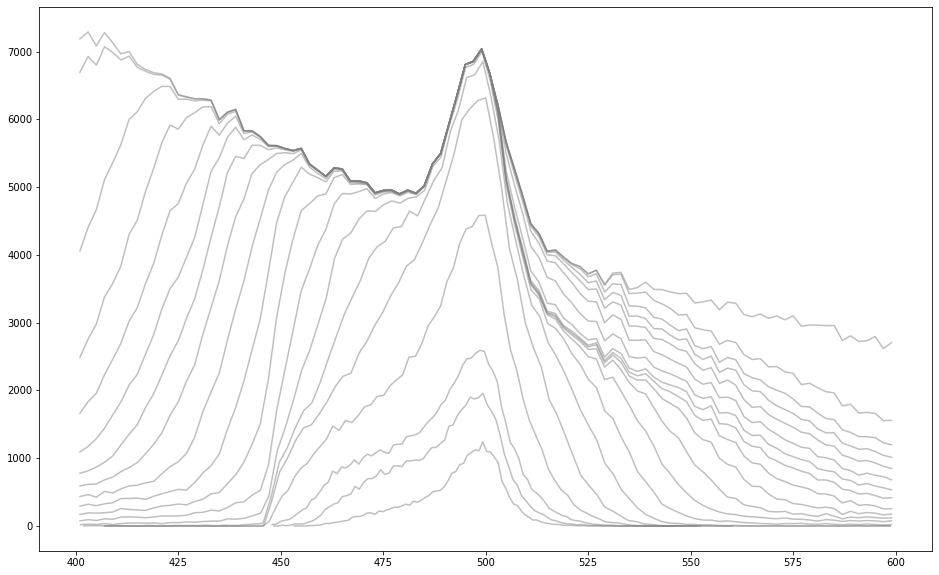

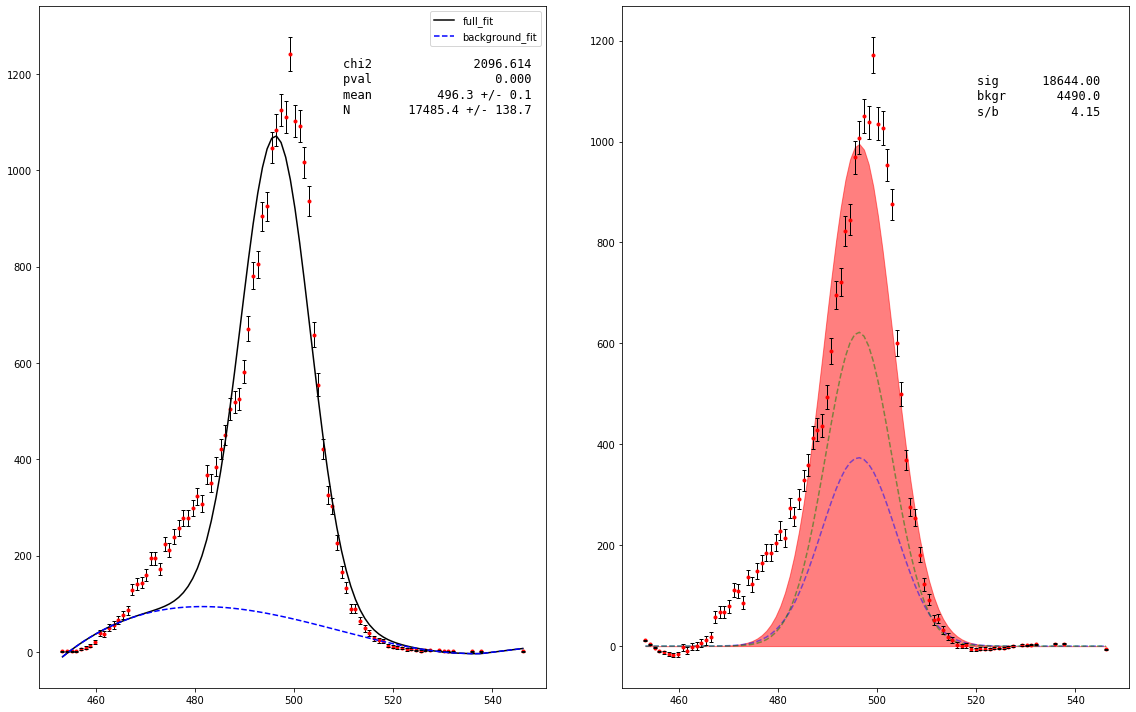

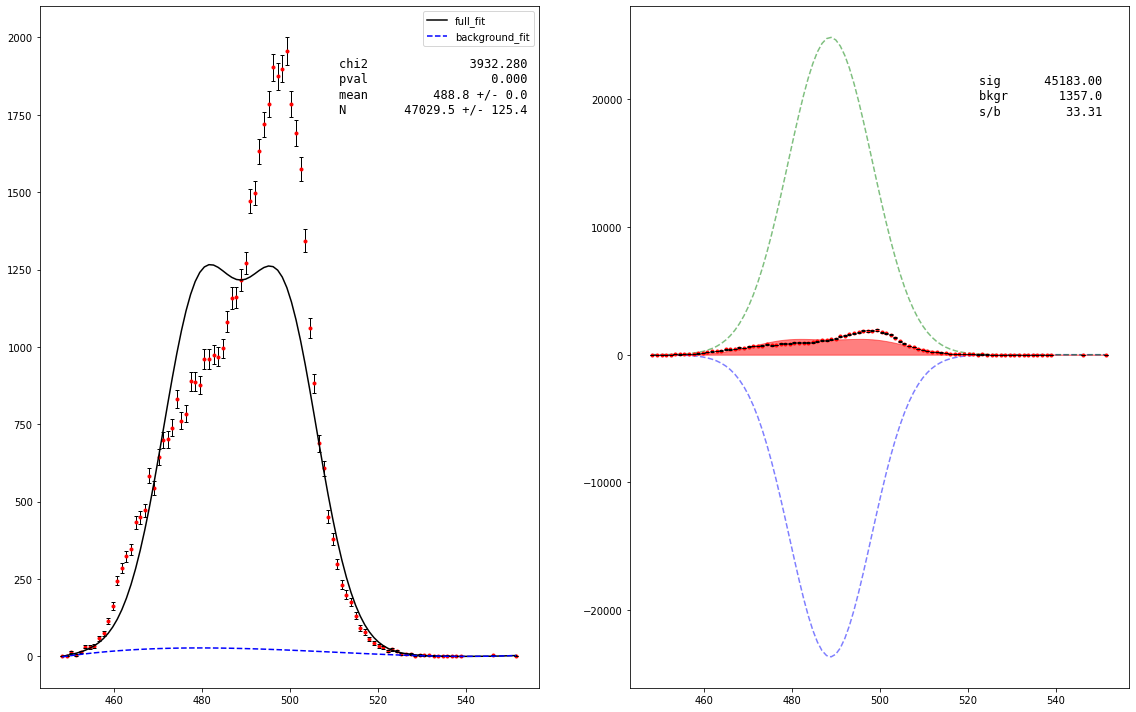

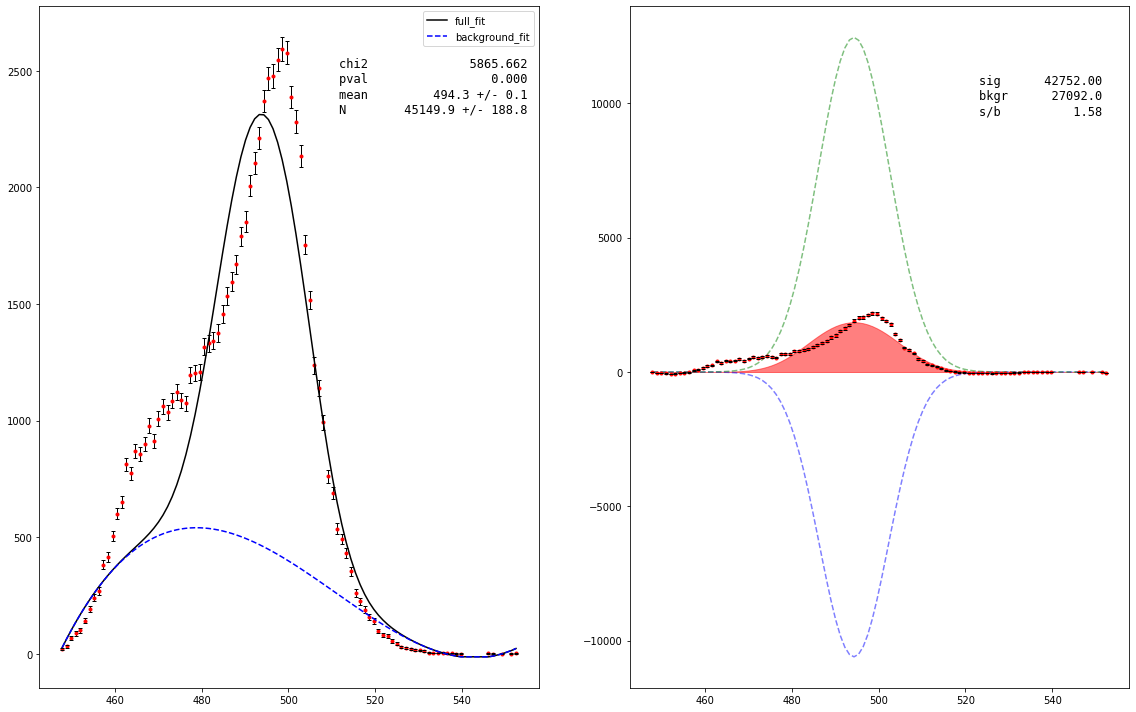

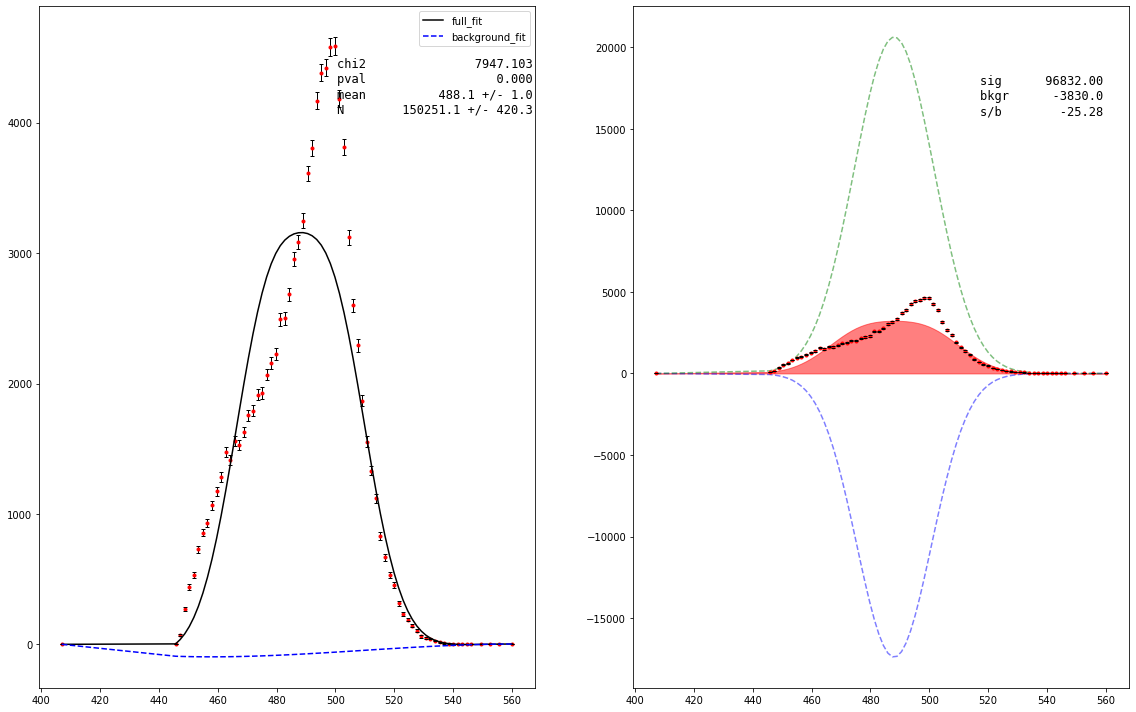

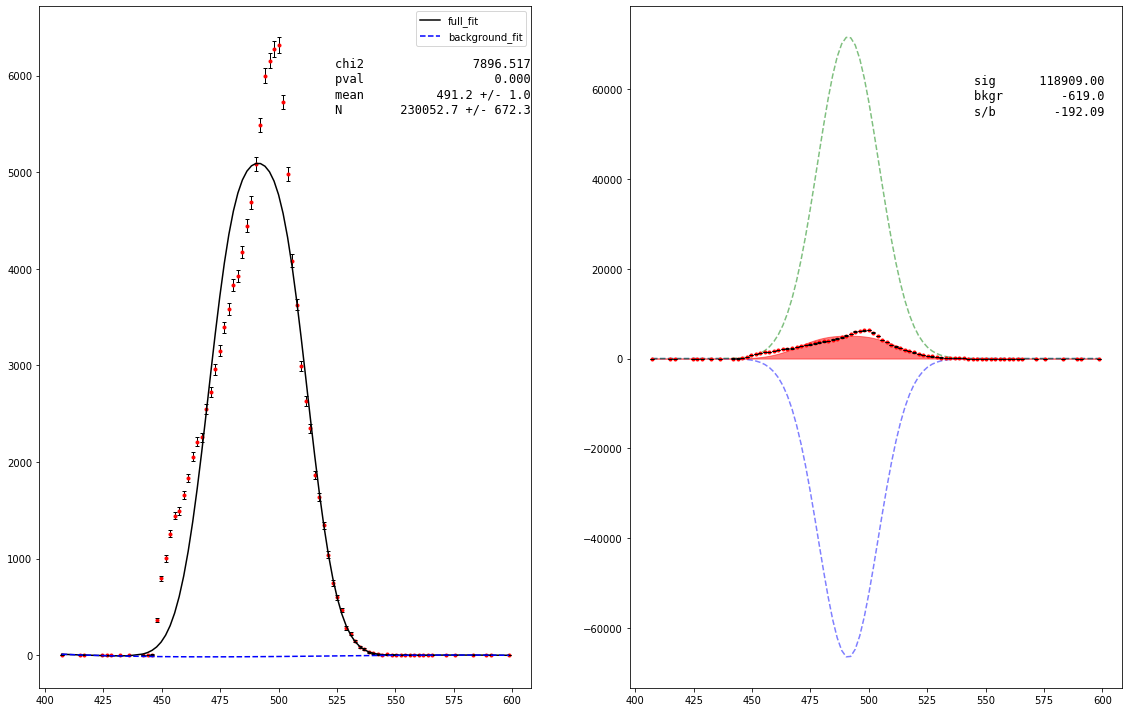

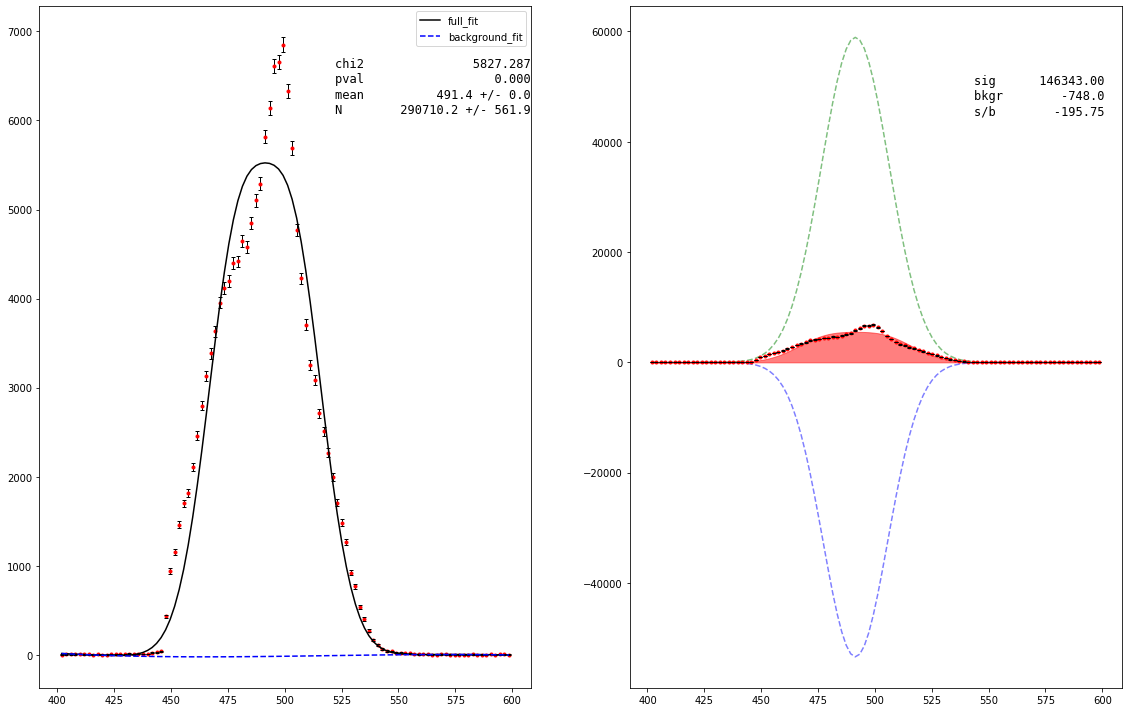

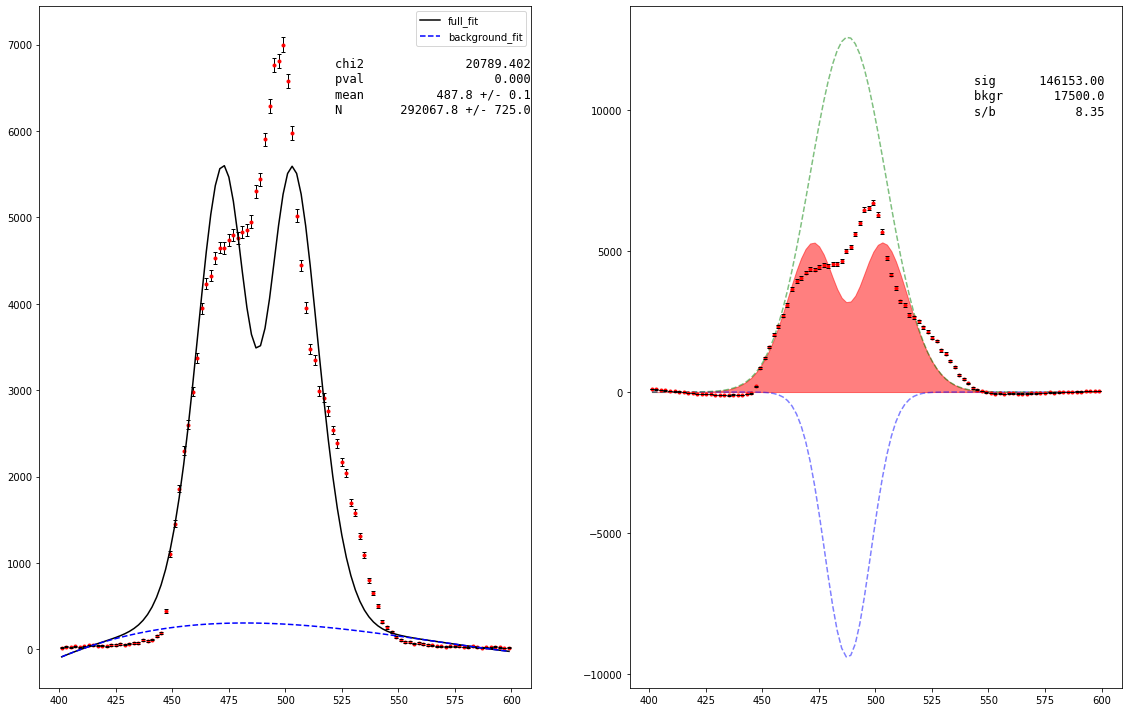

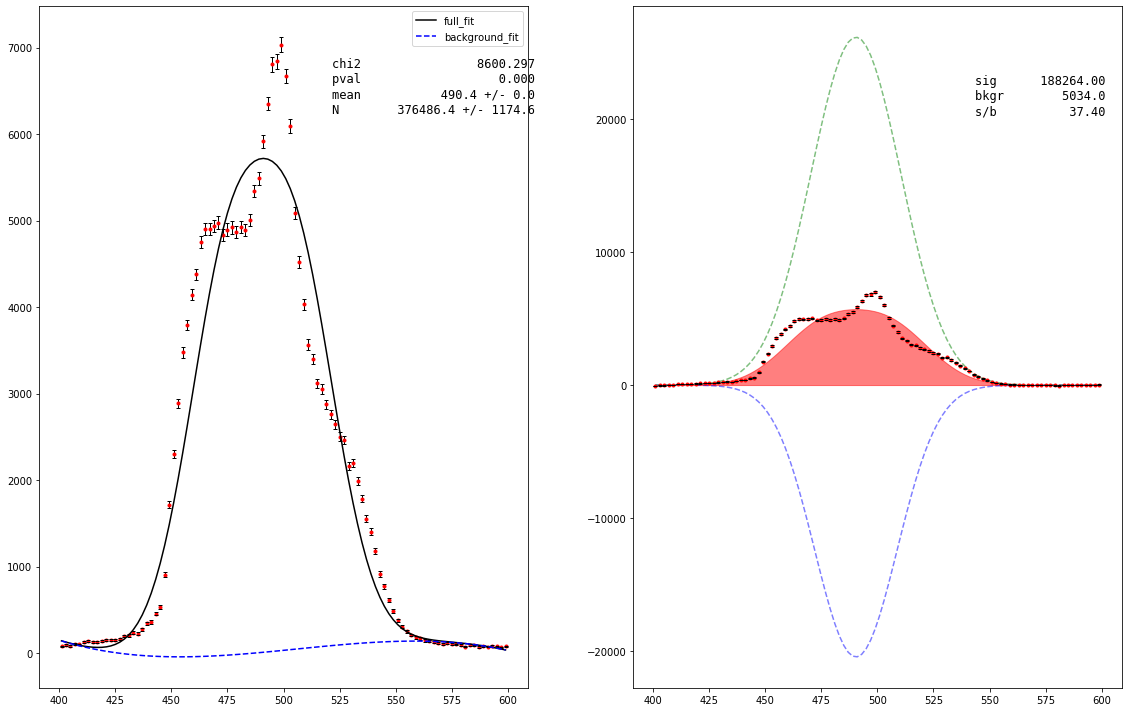

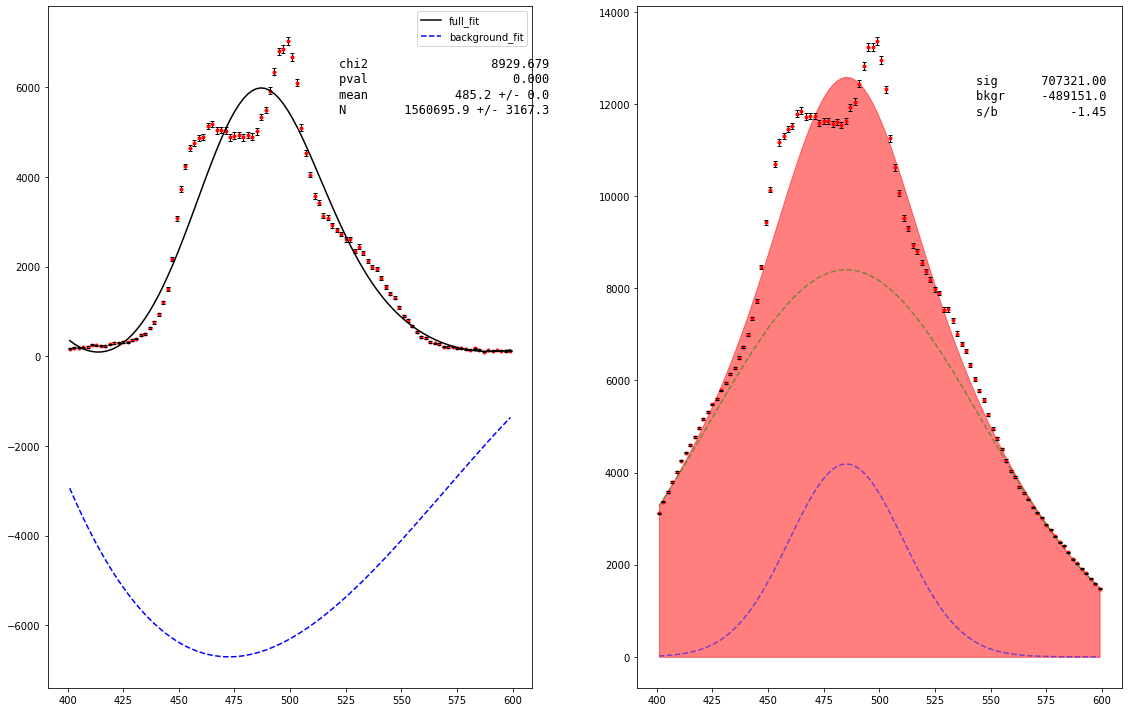

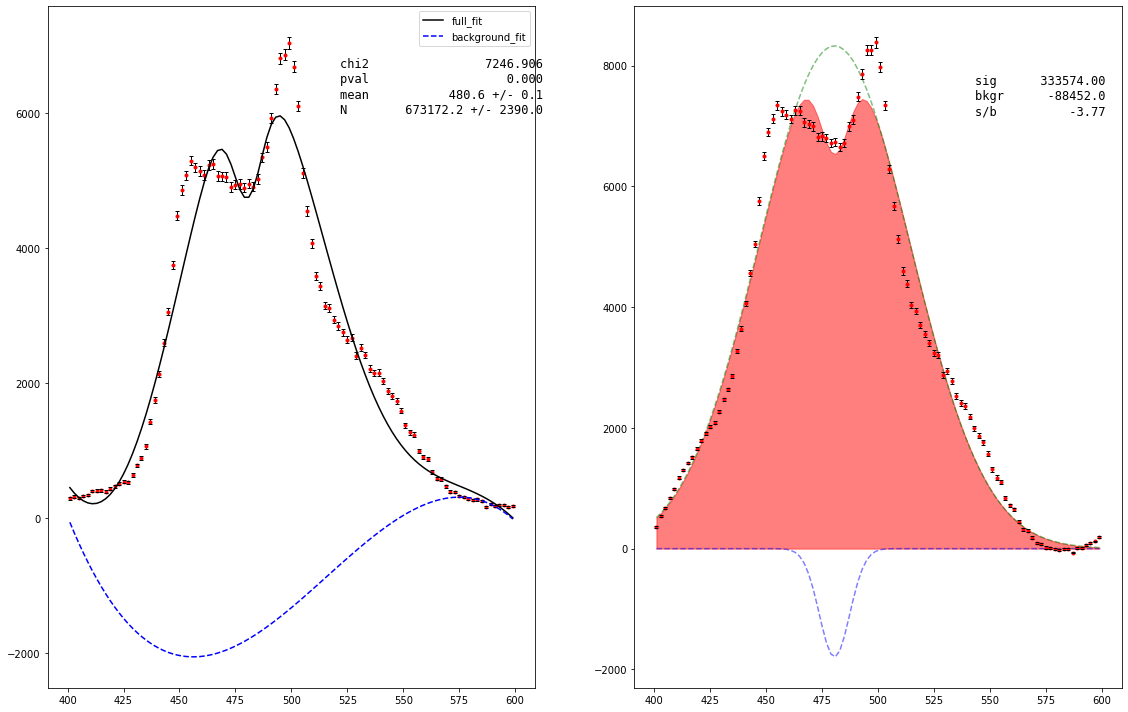

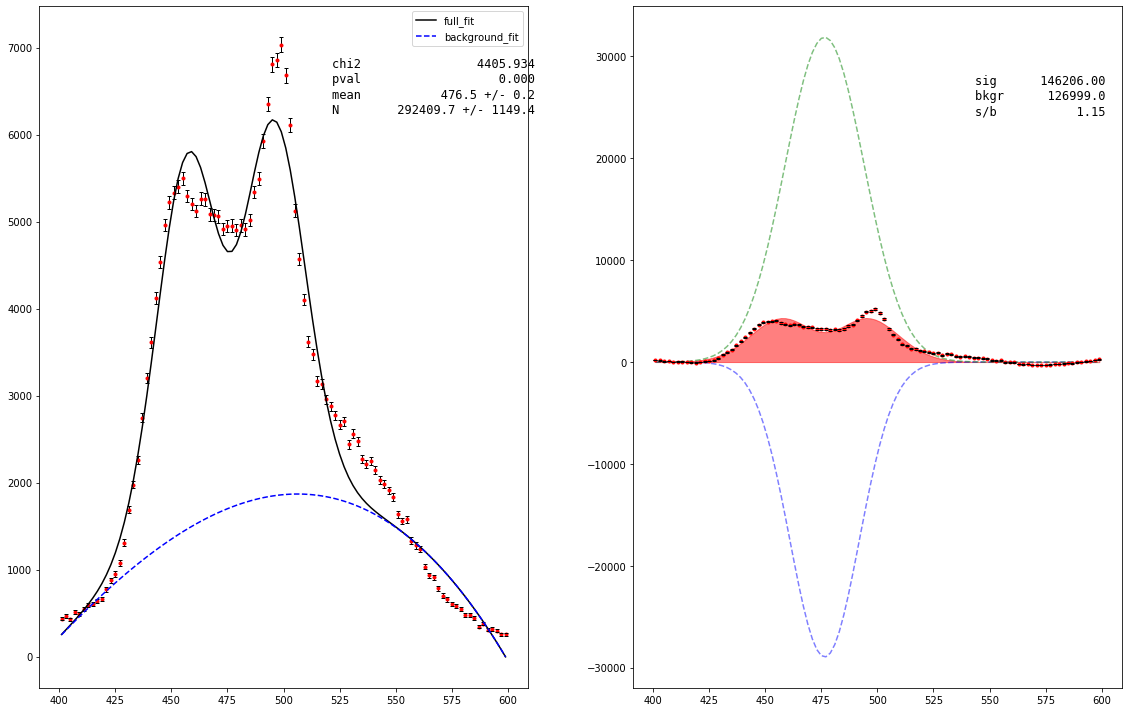

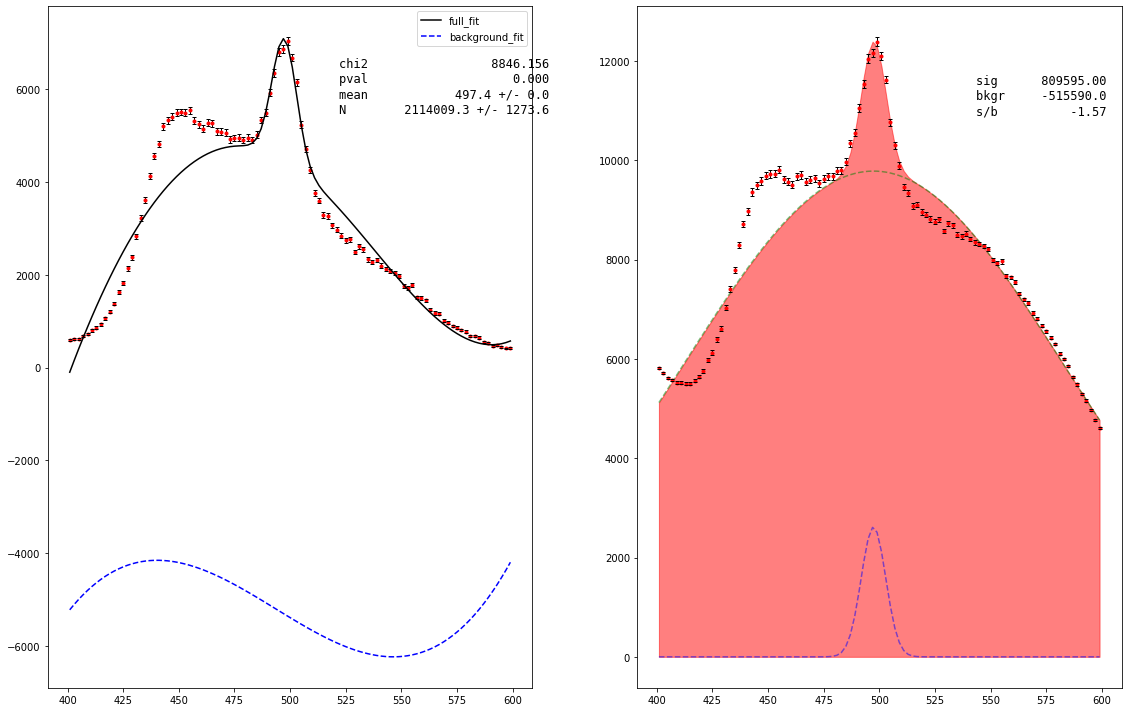

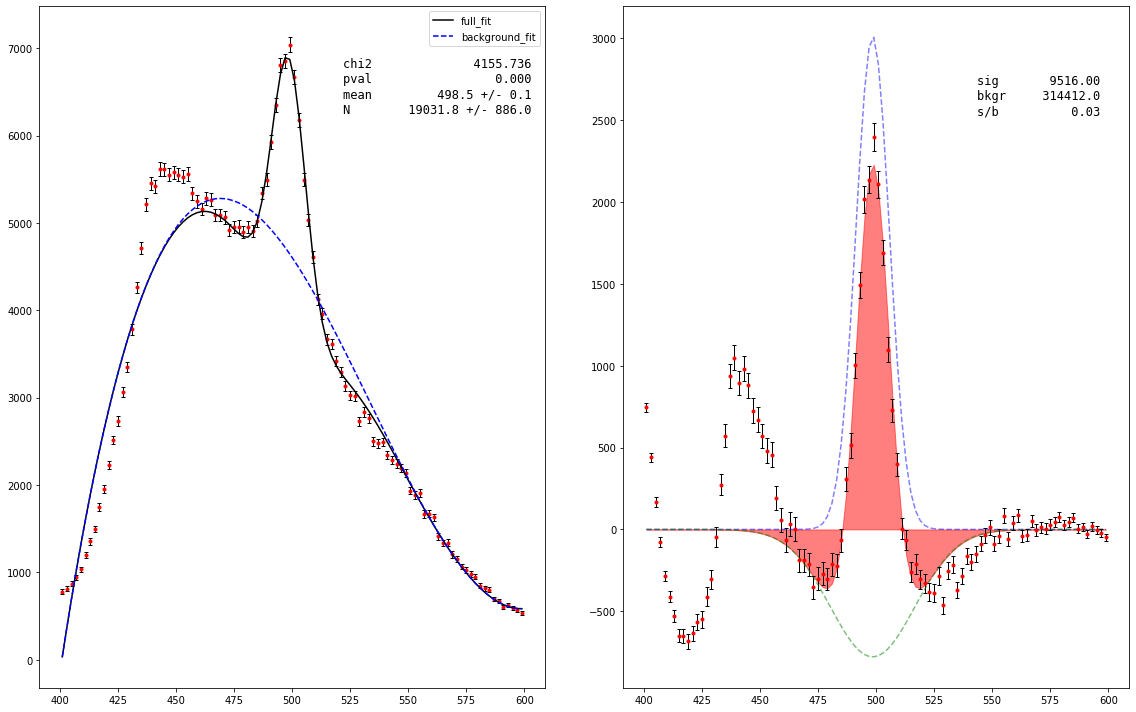

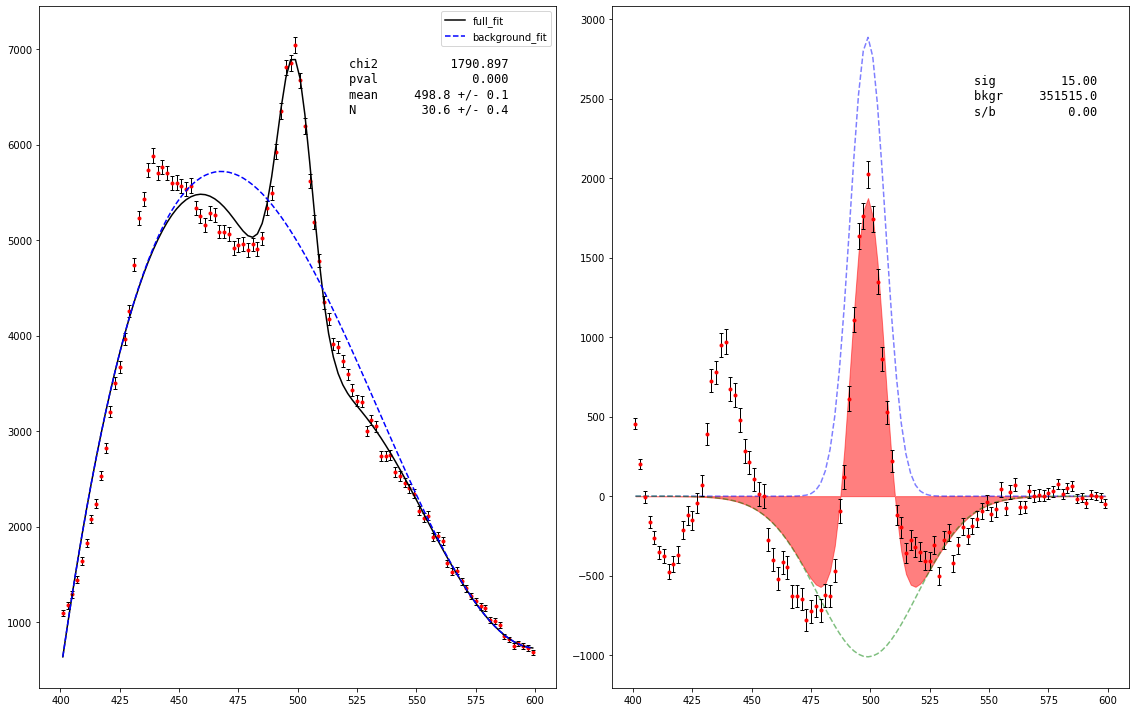

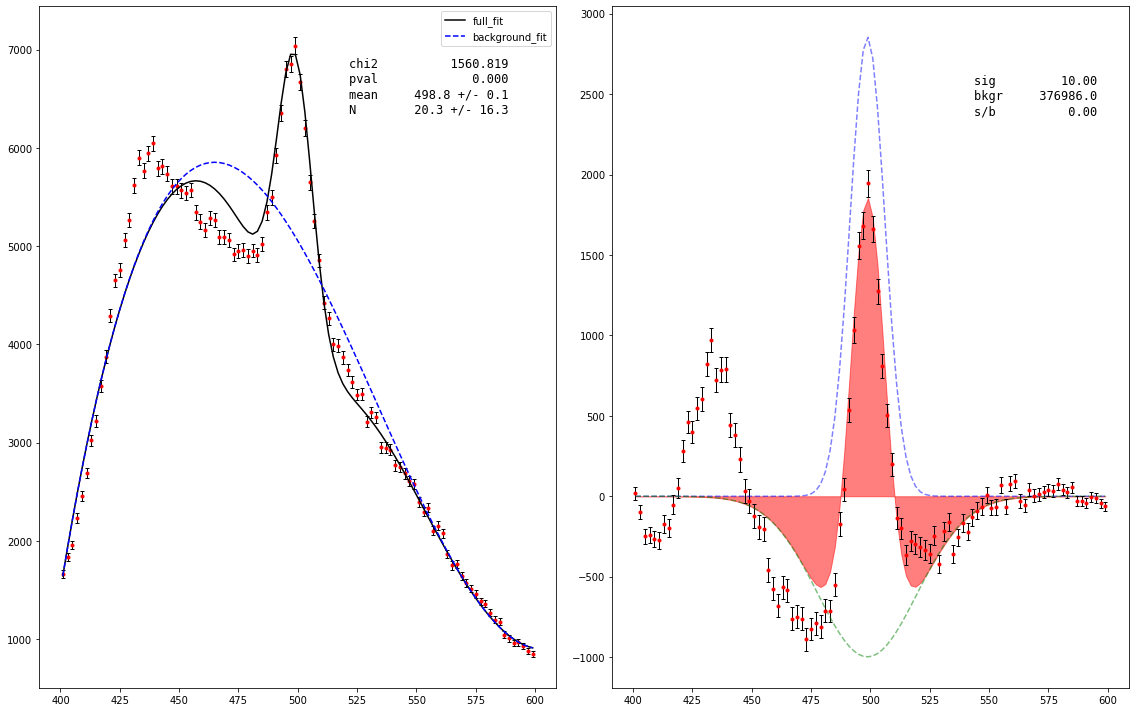

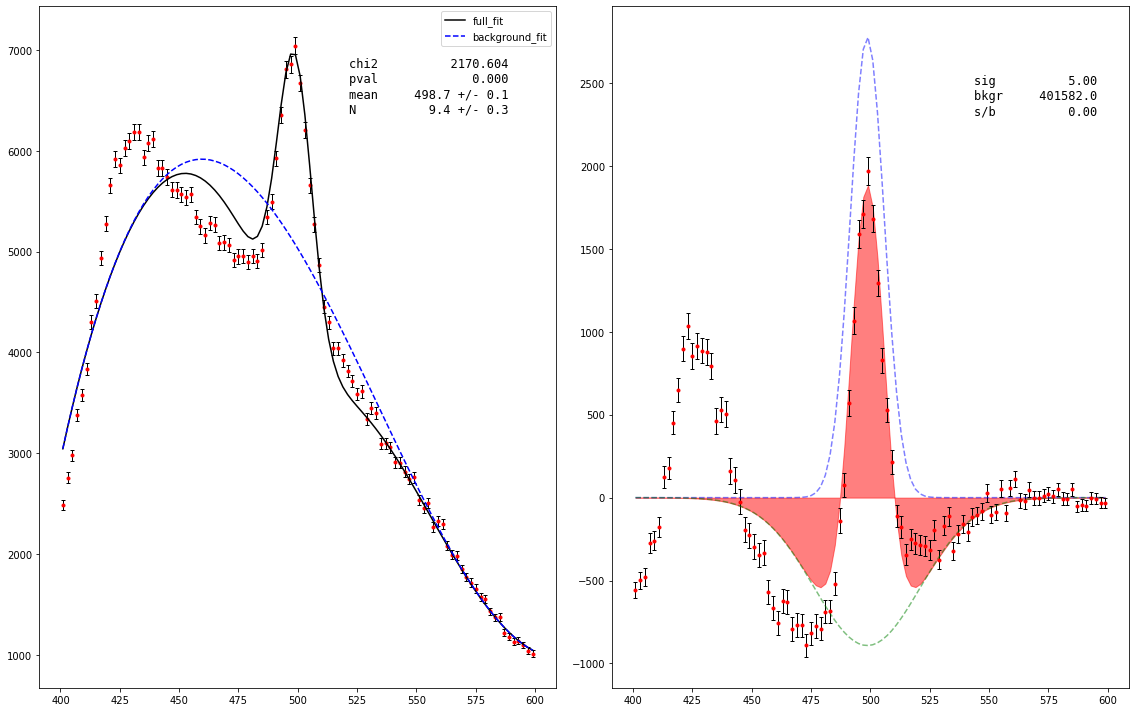

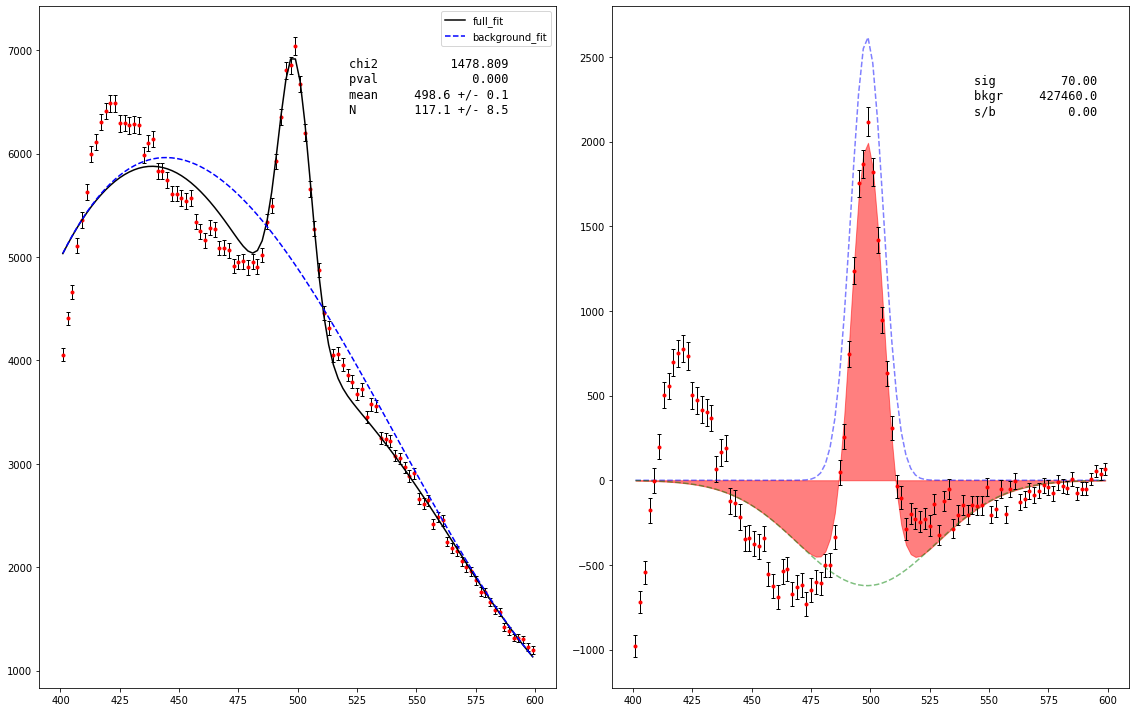

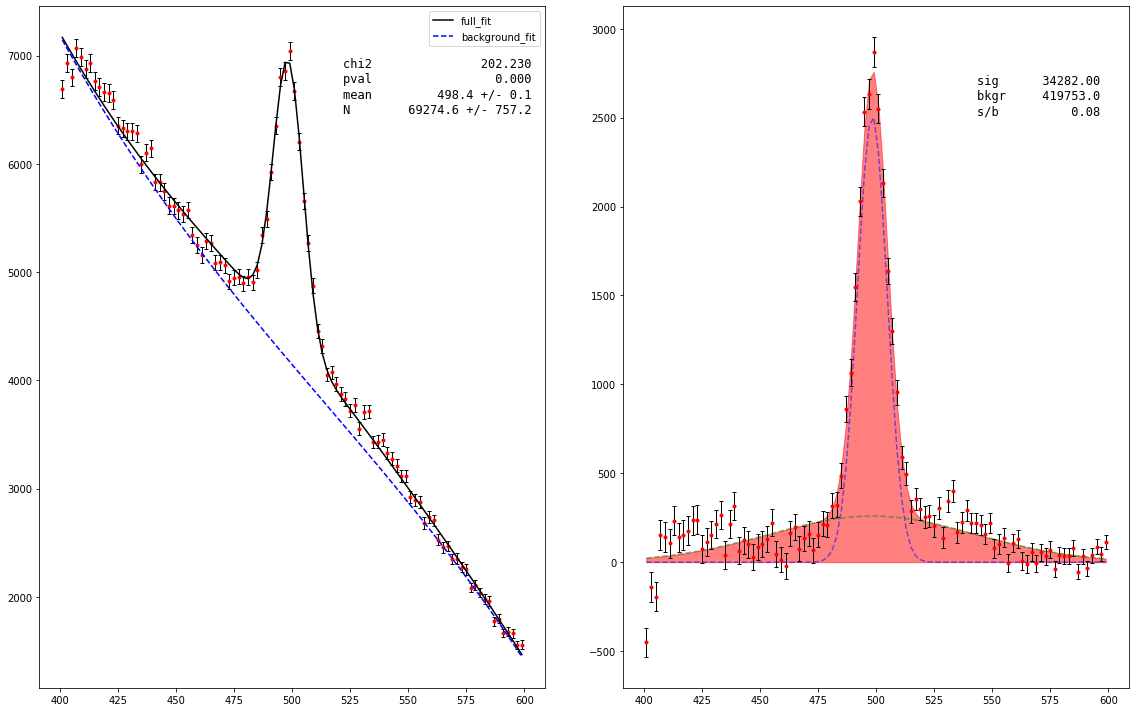

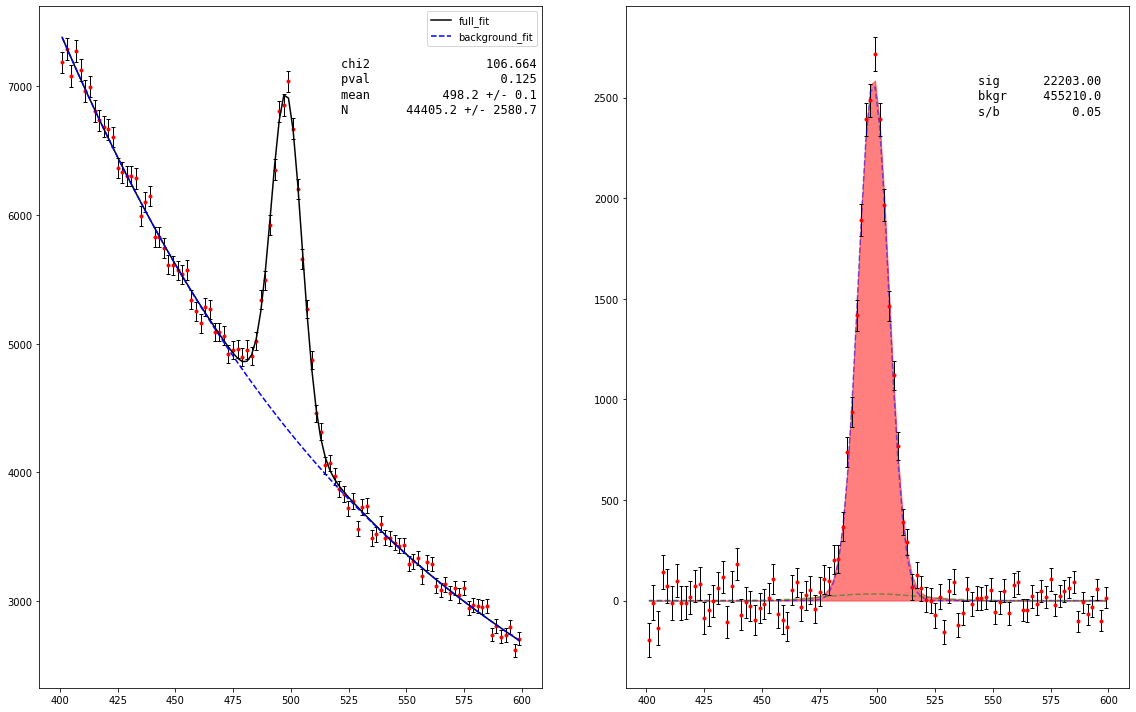

In [15]:
s, b, mask = hm.ROC_data(test_data.v0_ks_mass, pca_p)

test in MC

In [34]:
pca_p = pca_cla.predict_proba(np.concatenate([pca1.transform(test_mc[fs[0]]),
                            pca2.transform(test_mc[fs[1]]),
                            pca3.transform(test_mc[fs[2]]),
                            pca4.transform(test_mc[fs[3]]),
                            pca5.transform(test_mc[fs[4]])],axis=1))[:,1]
p = cla.predict_proba(test_mc[np.asarray(fs).sum()])[:,1]
all_pca_p = all_pca_cla.predict_proba(all_pca.transform(test_mc[np.asarray(fs).sum()]))[:,1]

In [36]:
roc_auc_score(test_mc.trueKs,pca_p), roc_auc_score(test_mc.trueKs,p), roc_auc_score(test_mc.trueKs,all_pca_p)

(0.8881328824915108, 0.9069483744665756, 0.8983622247967062)

C:\Users\jv97\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


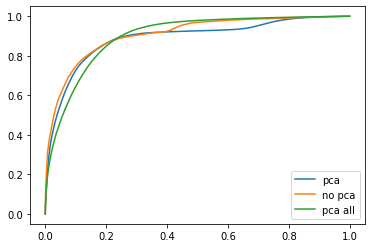

In [39]:
fig, ax = plt.subplots()
for i, prob in enumerate([pca_p,p,all_pca_p]):
    fpr, tpr, threshhold = roc_curve(test_mc.trueKs,prob)
    ax.plot(fpr,tpr,label=['pca','no pca','pca all'][i])
ax.legend()